In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tifffile import imread, imwrite
from skimage.measure import regionprops
from tqdm.notebook import tqdm
from anndata import AnnData


In [2]:
base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-02-06-Hongyu-Hongyu_multicap_covid_spleen_replicates1/'
image_path = os.path.join(base_path, 'images')
signal_path = os.path.join(base_path, 'signal')
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
if not os.path.exists(expr_path):
    os.mkdir(expr_path)

## QC

In [14]:
current_sample = 'sample3'
adata = sc.read_h5ad(os.path.join(expr_path, f'{current_sample}_raw.h5ad'))
raw_obs = adata.obs.copy()
n_cells_before = adata.obs.shape[0]

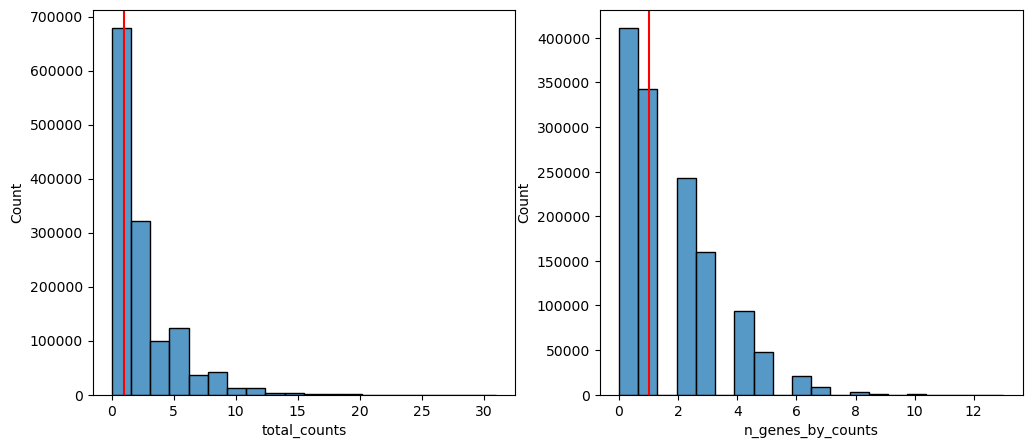

In [15]:
# calculate pp metric
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None)

# Calculate max count for each gene
adata.var['max_counts_sample'] = adata.X.max(axis=0)

# plot total_counts & n_genes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(adata.obs['total_counts'], bins=20, ax=axs[0])
axs[0].axvline(1, c='r')


sns.histplot(adata.obs['n_genes_by_counts'], bins=20, ax=axs[1])
axs[1].axvline(1, c='r')

# plt.savefig(os.path.join(fig_path, 'reads_filtering_threshold.pdf'))
plt.show()

In [16]:
# Filtration (cell)
min_counts = 1
# min_genes = 3

sc.pp.filter_cells(adata, min_counts=min_counts)
# sc.pp.filter_cells(adata, min_genes=min_genes)


adata.layers['raw'] = adata.X.copy()
n_cells_after = adata.obs.shape[0]
print(f"Number of cells before filtration: {n_cells_before}")
print(f"Number of cells after filtration: {n_cells_after}")
print(f"Percentage of cells kept: {n_cells_after/n_cells_before*100:.2f}%")

Number of cells before filtration: 1332061
Number of cells after filtration: 920871
Percentage of cells kept: 69.13%


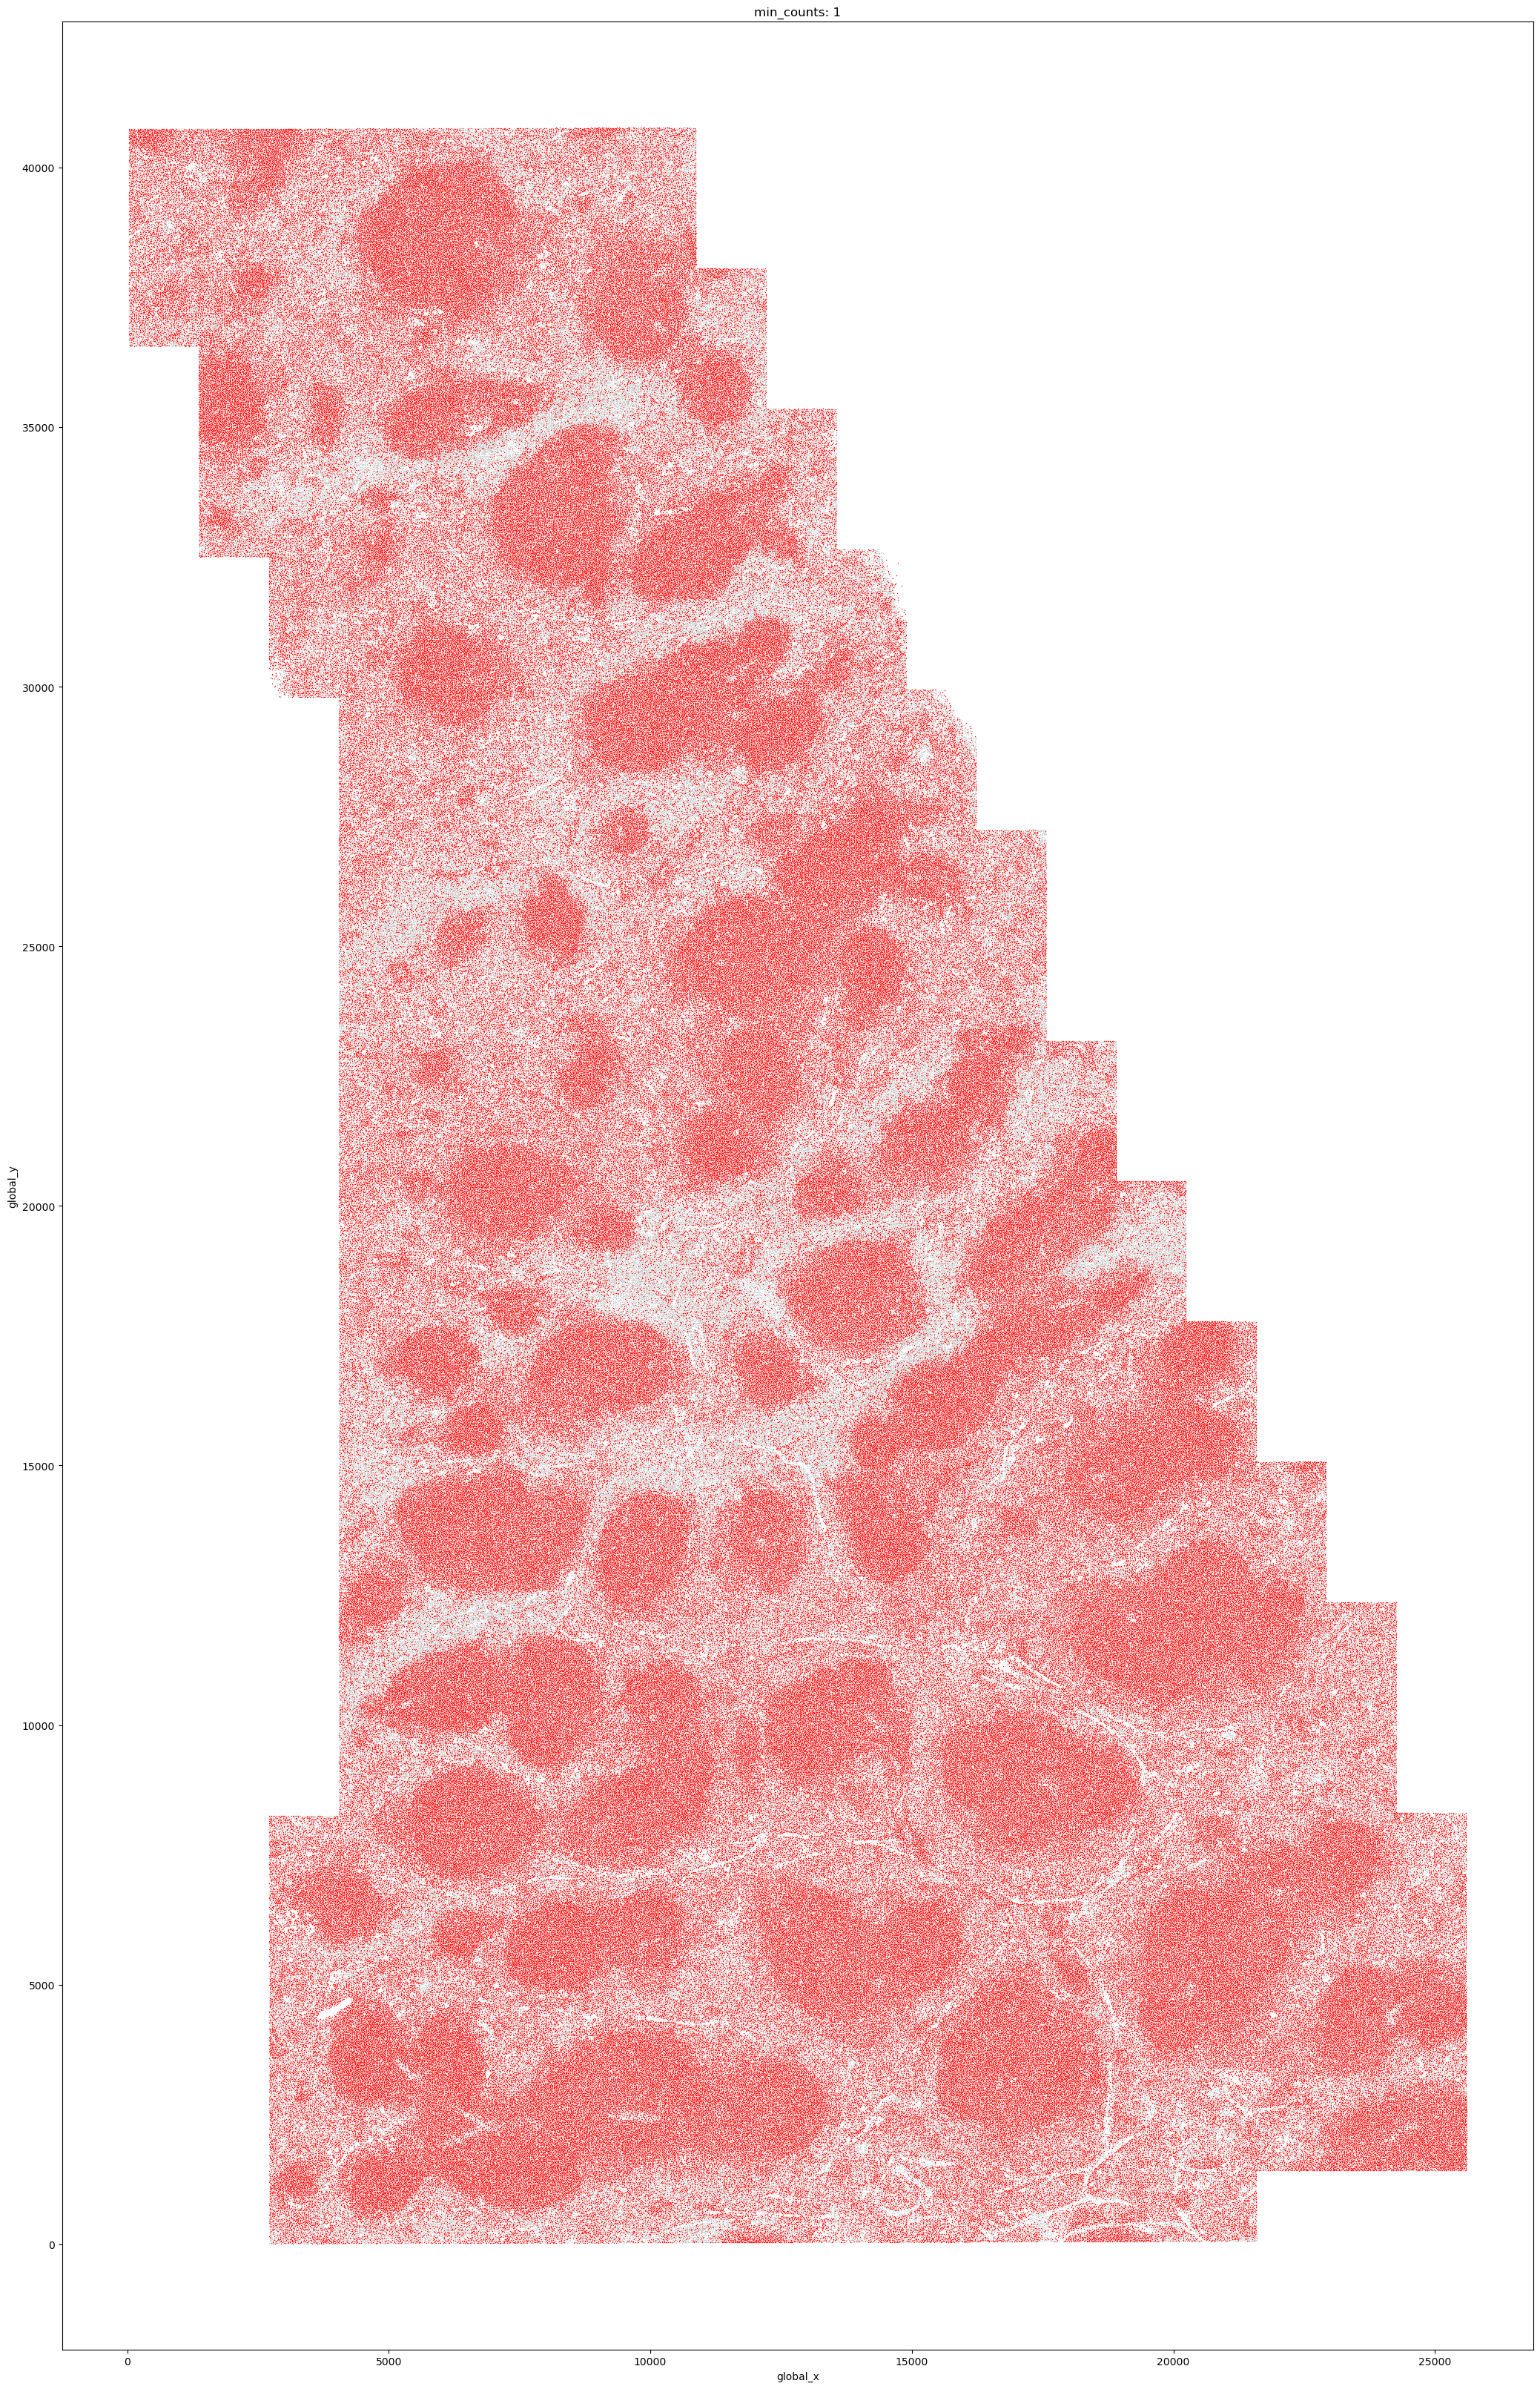

In [17]:
fig_size = np.array([raw_obs['global_x'].max(), raw_obs['global_y'].max()]) / 1000

fig, ax = plt.subplots(figsize=fig_size)
sns.scatterplot(x='global_x', y='global_y', color='#c2c2c2', data=raw_obs, s=1, ax=ax)
sns.scatterplot(x='global_x', y='global_y', color='r', data=adata.obs, s=1, ax=ax)
plt.title(f"min_counts: {min_counts}")
plt.show()

In [18]:
# save combined h5ad
# from datetime import datetime
# date = datetime.today().strftime('%Y-%m-%d')
# adata.write_h5ad(f"{expr_path}/{date}-{current_sample}-filtered.h5ad")
adata.write_h5ad(f"{expr_path}/{current_sample}-filtered.h5ad")

## Combine h5ad

In [19]:
sample_dict = {}
sample_dict["sample1"] = [i for i in range(1, 429 + 1)]
sample_dict["sample2"] = [i for i in range(430, 735 + 1)]
sample_dict["sample3"] = [i for i in range(736, 1096 + 1)]

In [20]:
adata_list = []

for current_sample in tqdm(np.unique(list(sample_dict.keys()))):
    current_adata = sc.read_h5ad(os.path.join(expr_path, f'{current_sample}-filtered.h5ad'))
    adata_list.append(current_adata)

cdata = ad.concat(adata_list, index_unique="_")
cdata.write_h5ad(f"{expr_path}/combined-filtered.h5ad")

  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
cdata

AnnData object with n_obs × n_vars = 2987133 × 61
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    layers: 'raw'

In [ ]:
# # subsample
# sc.pp.subsample(cdata, fraction=0.1)
# cdata.write_h5ad(f"{expr_path}/combined-filtered-103-subsample-01.h5ad")
# cdata